In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_excel("../data/titanic3.xls")


Clean the data

In [3]:
# change names
df = df.rename(columns={'pclass': 'Passenger Class', 'survived': 'Survived', 'age': 'Age', 'sibsp': 'Siblings/spouses aboard', 'parch': 'Parents/children aboard', 'fare': 'Passenger fare', 'embarked': 'Port of Embarkation', 'home.dest': 'Home/Destination'})
# create binary columns for sex and alone
df['sex'] = df['sex'].apply(lambda x: 0 if str(x) == 'male' else 1)
df['alone'] = df.apply(lambda row: 1 if row['Parents/children aboard'] == 0 and row['Siblings/spouses aboard'] == 0 else 0, axis=1)
# fill null values for age and fare
df['Age'].fillna(value=df['Age'].mean(), inplace=True)
df['Passenger fare'].fillna(value=df['Passenger fare'].mean(), inplace=True)
# drop unused columns
df.drop(['cabin', 'boat', 'body', 'ticket', 'name', 'Port of Embarkation', 'Home/Destination'], axis=1, inplace=True)


In [4]:
#change order of columns
new_order = ['sex', 'Survived', 'alone', 'Siblings/spouses aboard', 'Parents/children aboard', 'Passenger fare']
df = df[new_order]

df.head(5)

,sex,Survived,alone,Siblings/spouses aboard,Parents/children aboard,Passenger fare
0,1,1,1,0,0,211.3375
1,0,1,0,1,2,151.5500
2,1,0,0,1,2,151.5500
3,0,0,0,1,2,151.5500
4,1,0,0,1,2,151.5500


<Axes: >

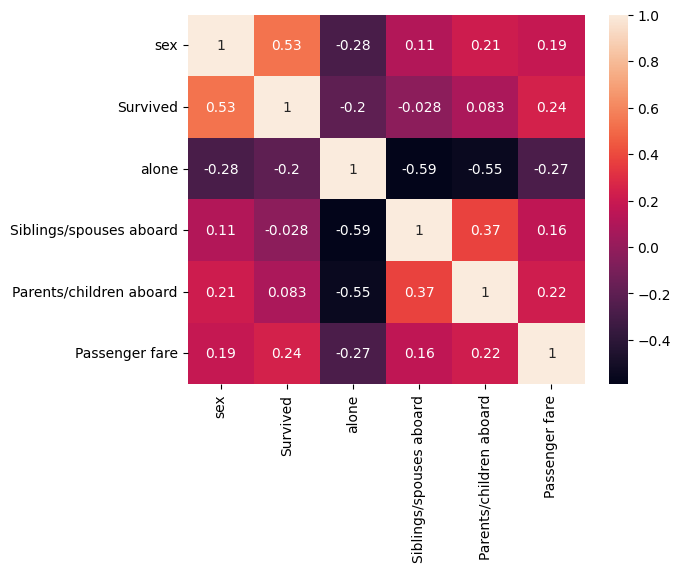

In [5]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

In [6]:
corr['Survived'].sort_values(ascending=False)

Survived                   1.000000
sex                        0.528693
Passenger fare             0.244208
Parents/children aboard    0.082660
Siblings/spouses aboard   -0.027825
alone                     -0.201719
Name: Survived, dtype: float64

In [7]:
df.describe()

,sex,Survived,alone,Siblings/spouses aboard,Parents/children aboard,Passenger fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.355997,0.381971,0.603514,0.498854,0.385027,33.295479
std,0.478997,0.486055,0.489354,1.041658,0.865560,51.738879
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,7.895800
50%,0.000000,0.000000,1.000000,0.000000,0.000000,14.454200
75%,1.000000,1.000000,1.000000,1.000000,0.000000,31.275000
max,1.000000,1.000000,1.000000,8.000000,9.000000,512.329200


Based on the correlation, it seems that alone may be an interesting feature, let's try it out by looking at an xgboost model.

In [8]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f'Accuracy: {accuracy}')

# Access the feature importance scores
feature_importance = model.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance scores
print(feature_importance_df)

Accuracy: 0.732824427480916
                   Feature  Importance
0                      sex    0.789972
2  Siblings/spouses aboard    0.069265
3  Parents/children aboard    0.067462
4           Passenger fare    0.048815
1                    alone    0.024486


Based on this alone does not seem to be a feature that is important for the training of models, but as it does have the high correlation we have decided to keep it in regardless.